# Přiřazovací problém

Přiřazovací problém řeší situace, kdy chceme **navzájem jednoznačně** přiřadit prvky ze dvou množin tak, aby bylo:

- **minimalizováno** (nebo maximalizováno) celkové ohodnocení přiřazení,
- každému prvku na levé straně odpovídal **právě jeden** prvek na pravé straně,
- a naopak – každému prvku na pravé straně byl přiřazen **právě jeden** prvek zleva.

Typické příklady:

- přiřazení pracovníků k úlohám / strojům,
- přiřazení uchazečů k pozicím,
- přiřazení letadel k letům, atd.

Přirozeně se to popisuje jako **bipartitní graf**:

- vlevo vrcholy $U = \{u_1,\dots,u_n\}$ (např. pracovníci),
- vpravo vrcholy $V = \{v_1,\dots,v_n\}$ (např. úlohy),
- hrana $(u_i, v_j)$ má ohodnocení $c_{ij}$ (cena, škoda, čas…).

Hledáme tzv. **perfektní párování** (matching) – množinu hran tak, aby každý vrchol měl právě jednu incidentní (sousední) vybranou hranu – a zároveň aby součet ohodnocení vybraných hran byl minimální.

Níže si demonstrujeme bipartitní graf $K_{n,n}$ a matici omezujících podmínek, jejíž hodnost je $2n-1$. Velikost $n$ si můžete měnit pomocí posuvníku.


Shape of A: (6, 9)
Rank of A:  5 (očekává se 2n - 1 = 5)

Matice A (2n × n^2):


x11  x12  x13  x21  x22  x23  x31  x32  x33
r1    1    1    1    0    0    0    0    0    0
r2    0    0    0    1    1    1    0    0    0
r3    0    0    0    0    0    0    1    1    1
r4    1    0    0    1    0    0    1    0    0
r5    0    1    0    0    1    0    0    1    0
r6    0    0    1    0    0    1    0    0    1

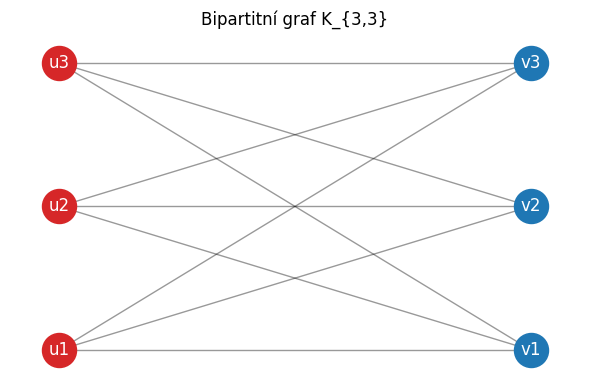

In [7]:
#@title Dimenze problému, matice A a bipartitní graf { run: "auto", vertical-output: true }
n = 3  #@param {type:"slider", min:2, max:12, step:1}

# If needed, install the libraries once:
# !pip install numpy networkx matplotlib

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------
# 1) Konstrukce matice A (2n × n^2)
# ------------------------------
# Prvních n řádků: součty v jednotlivých řádcích (pracovníci)
# Posledních n řádků: součty v jednotlivých sloupcích (úlohy)

A = np.zeros((2 * n, n * n))

# Row-sum constraints: for each i, x_{i,1} + ... + x_{i,n} = 1
for i in range(n):
    A[i, i * n : (i + 1) * n] = 1.0

# Column-sum constraints: for each j, x_{1,j} + ... + x_{n,j} = 1
# This is I_n tiled horizontally n times.
A[n:, :] = np.tile(np.identity(n), n)

rank_A = np.linalg.matrix_rank(A)

print(f"Shape of A: {A.shape}")
print(f"Rank of A:  {rank_A} (očekává se 2n - 1 = {2 * n - 1})")

if n <= 5:
    # Pojmenujeme si sloupce x_ij kvůli přehlednosti
    col_names = [f"x{i+1}{j+1}" for i in range(n) for j in range(n)]
    row_names = [f"r{i+1}" for i in range(2 * n)]
    dfA = pd.DataFrame(A.astype(int), index=row_names, columns=col_names)
    print("\nMatice A (2n × n^2):")
    display(dfA)
else:
    print("\nMatice A je velká (2n × n^2), nastav n ≤ 5, pokud ji chceš vidět celou jako tabulku.")


# ------------------------------
# 2) Bipartitní graf K_{n,n}
# ------------------------------
# Left part: workers u_1,...,u_n
# Right part: jobs v_1,...,v_n

workers = [f"u{i+1}" for i in range(n)]
jobs = [f"v{j+1}" for j in range(n)]

G = nx.Graph()
G.add_nodes_from(workers, bipartite=0)
G.add_nodes_from(jobs, bipartite=1)

# Complete bipartite graph: connect each worker with each job
for u in workers:
    for v in jobs:
        G.add_edge(u, v)

# Simple left-right layout
pos = {}
for i, u in enumerate(workers):
    pos[u] = (0, i)
for j, v in enumerate(jobs):
    pos[v] = (1, j)

plt.figure(figsize=(6, 4))
# Draw edges lightly
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Draw left and right nodes in different colors
nx.draw_networkx_nodes(G, pos, nodelist=workers, node_color="tab:red", node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=jobs, node_color="tab:blue", node_size=600)
# Add labels
nx.draw_networkx_labels(G, pos, font_color="white")

plt.title(f"Bipartitní graf K_{{{n},{n}}}")
plt.axis("off")
plt.tight_layout()
plt.show()


## Formulace přiřazovacího problému jako LP / binárního programu

Uvažujme dvě stejně velké množiny:

- pracovníci $ i = 1,\dots,n $,
- úlohy (stroje, zařízení…) $ j = 1,\dots,n $.

Nechť $ c_{ij} $ je cena nebo škoda, když pracovník $ i $ vykonává úlohu $ j $.  
Zavedeme binární proměnnou

$$
x_{ij} =
\begin{cases}
1, & \text{pokud je pracovník } i \text{ přiřazen k úloze } j, \\
0, & \text{jinak}.
\end{cases}
$$

### Minimalizační úloha

$$
\min z = \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij}
$$

za podmínek

1. **Každý pracovník má přesně jednu úlohu**

$$
\sum_{j=1}^{n} x_{ij} = 1, \quad i = 1,\dots,n.
$$

2. **Každá úloha je obsazena právě jedním pracovníkem**

$$
\sum_{i=1}^{n} x_{ij} = 1, \quad j = 1,\dots,n.
$$

3. **Binární podmínka**

$$
x_{ij} \in \{0,1\}, \quad i,j = 1,\dots,n.
$$

V maticovém zápisu si můžeme vytvořit vektor

$$
x = (x_{11}, x_{12}, \dots, x_{1n}, x_{21}, \dots, x_{nn})^T \in \mathbb{R}^{n^2},
$$

a matici $ A \in \mathbb{R}^{2n \times n^2} $, kde:

- prvních $n$ řádků vyjadřuje omezení pro pracovníky,
- posledních $n$ řádků omezení pro úlohy.

Potom lze podmínky zapsat jako

$$
A x = \mathbf{1}_{2n},
$$

kde $\mathbf{1}_{2n}$ je vektor všech jedniček délky $2n$. **Hodnost** matice $A$ je

$$
\operatorname{rank}(A) = 2n - 1,
$$

což odpovídá tomu, že jedna z rovnic je lineárně závislá.

---

## Praktický příklad – přiřazení pracovníků ke strojům

Uvažujme 4 pracovníky a 4 stroje. Hodnoty v tabulce udávají **škodu (např. v Kč)**, kterou pracovník způsobí, pokud bude pracovat na daném stroji. Chceme zvolit přiřazení tak, aby byla **celková škoda minimální**.

|        | Soustruh | Pila | Žehlička | Autogen |
|--------|:--------:|:----:|:--------:|:-------:|
| Jirka  |   100    |  80  |    90    |   50    |
| Karel  |   150    |  80  |    50    |   50    |
| Pavla  |    40    | 100  |    80    |   40    |
| Milena |    50    |  90  |    90    |   60    |

Proměnná $x_{\text{Jirka},\text{Pila}} = 1$ například znamená, že Jirka pracuje u pily.

V následující buňce:

1. zadefinujeme tuto tabulku jako matici nákladů,
2. sestavíme binární LP model v knihovně **PuLP**,
3. najdeme optimální přiřazení,
4. vypíšeme výslednou matici $x_{ij}$,
5. vykreslíme **bipartitní graf**, kde červené hrany odpovídají optimálnímu přiřazení.


Cost matrix (damage if worker uses a machine):
        Soustruh  Pila  Žehlička  Autogen
Jirka        100    80        90       50
Karel        150    80        50       50
Pavla         40   100        80       40
Milena        50    90        90       60 

Solver status: Optimal
Optimal total cost: 220.0 

Assignment matrix (1 = chosen pair, 0 = not used):
            Soustruh      Pila  Žehlička   Autogen
--------------------------------------------------
Jirka              0         1         0         0
Karel              0         0         1         0
Pavla              0         0         0         1
Milena             1         0         0         0

Optimal assignment (worker -> machine):
Jirka → Pila (cost = 80)
Karel → Žehlička (cost = 50)
Pavla → Autogen (cost = 40)
Milena → Soustruh (cost = 50)


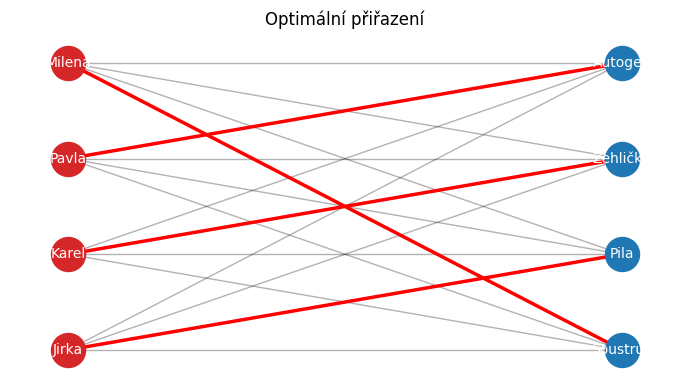

In [8]:
# ----------------------------------------------------------
# Praktický příklad přiřazovacího problému v PuLP
# ----------------------------------------------------------

# If needed, install these packages once:
# !pip install pulp pandas networkx matplotlib

import pandas as pd
import pulp
import networkx as nx
import matplotlib.pyplot as plt

# --- Cost matrix: workers (rows) × machines (columns) ---
workers = ["Jirka", "Karel", "Pavla", "Milena"]
data = {
    "Soustruh": [100, 150,  40,  50],
    "Pila":      [80,  80, 100,  90],
    "Žehlička":  [90,  50,  80,  90],
    "Autogen":   [50,  50,  40,  60],
}
cost_df = pd.DataFrame(data, index=workers)
machines = list(cost_df.columns)

print("Cost matrix (damage if worker uses a machine):")
print(cost_df, "\n")

# --- Build the assignment model ---
model = pulp.LpProblem("Prirazovaci_problem", sense=pulp.LpMinimize)

# Binary decision variables x[worker][machine] ∈ {0,1}
x = pulp.LpVariable.dicts(
    "x",
    (workers, machines),
    lowBound=0,
    upBound=1,
    cat=pulp.LpBinary,
)

# Objective: minimize total cost
model += pulp.lpSum(
    cost_df.loc[w, m] * x[w][m]
    for w in workers
    for m in machines
), "Total_cost"

# Each worker is assigned to exactly one machine
for w in workers:
    model += (
        pulp.lpSum(x[w][m] for m in machines) == 1,
        f"Worker_{w}_exactly_one_machine",
    )

# Each machine is used by exactly one worker
for m in machines:
    model += (
        pulp.lpSum(x[w][m] for w in workers) == 1,
        f"Machine_{m}_exactly_one_worker",
    )

# --- Solve the model ---
status = model.solve()

print("Solver status:", pulp.LpStatus[status])
print("Optimal total cost:", pulp.value(model.objective), "\n")

# --- Assignment matrix 0/1 ---
print("Assignment matrix (1 = chosen pair, 0 = not used):")
header = "{:<10}".format("") + "".join(f"{m:>10}" for m in machines)
print(header)
print("-" * len(header))

chosen_edges = []  # to store optimal pairs for the graph

for w in workers:
    row_str = "{:<10}".format(w)
    for m in machines:
        val = x[w][m].value()
        if val is None:
            val = 0.0
        if val > 0.5:  # chosen edge
            chosen_edges.append((w, m))
        row_str += f"{int(round(val)):10d}"
    print(row_str)

print("\nOptimal assignment (worker -> machine):")
for w, m in chosen_edges:
    print(f"{w} → {m} (cost = {cost_df.loc[w, m]})")

# ----------------------------------------------------------
# Visualization: bipartite graph with optimal assignment
# ----------------------------------------------------------

G = nx.Graph()
G.add_nodes_from(workers, bipartite=0)
G.add_nodes_from(machines, bipartite=1)

# Add all possible edges with weights
for w in workers:
    for m in machines:
        G.add_edge(w, m, weight=cost_df.loc[w, m])

# Layout: workers on the left, machines on the right
pos = {}
for i, w in enumerate(workers):
    pos[w] = (0, i)
for j, m in enumerate(machines):
    pos[m] = (1, j)

plt.figure(figsize=(7, 4))

# Draw all edges in light gray
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw optimal edges in red and thicker
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=chosen_edges,
    width=2.5,
    edge_color="red",
)

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=workers, node_color="tab:red", node_size=600)
nx.draw_networkx_nodes(G, pos, nodelist=machines, node_color="tab:blue", node_size=600)

# Node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white")

# Edge labels = costs
edge_labels = {
    (w, m): cost_df.loc[w, m] for w in workers for m in machines
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=[], font_size=8)

plt.title("Optimální přiřazení")
plt.axis("off")
plt.tight_layout()
plt.show()
